In [91]:
import pandas as pd
import torch
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [92]:
cfg = {
    'DIR': '../dataset/',
    'train_path': 'train.json',
    'test_path': 'test.json',
    'dev_path': 'dev.json',
}

In [93]:
import os

def load_data(path: str) -> json:
    with open(os.path.join(cfg['DIR'], path), 'r') as f:
        data = json.load(f)
    return data

In [94]:
import re

def clean_str(str: str) -> str:
    # remove '\n' character
    str = str.replace('\n', ' ')
    # remove '\t' character
    str = re.sub(r'\\t', ' ', str)
    # remove '\r' character
    str = re.sub(r'\\r', ' ', str)
    # remove more than 2 consecutive occcurance of a character
    str = re.sub(r'(.)\1{2,}', r'\1', str)
    return str.strip().lower()

In [95]:
def clean_data(data: dict) -> None:
    for i in range(len(data['documents'])):
        data['documents'][i]['text'] = clean_str(data['documents'][i]['text'])

In [96]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from tqdm import tqdm
# def get_Ypred_Ytrue(data: dict, tfidf: TfidfVectorizer, hypothesis: dict, labels: dict, threshold : float = 0.1) -> (list, list):
    
#     X = []
#     Y = []

#     Y_pred = []
#     Y_true = []

#     hypothesis_vecs = {}
#     for key, val in hypothesis.items():
#         hypothesis_vecs[key] = tfidf.transform([val])

#     for i in tqdm(range(len(data["documents"]))):
#         doc_text = data["documents"][i]["text"]
#         tokenized_doc = nltk.word_tokenize(doc_text)

#         for i, span in enumerate(data["documents"][i]["spans"]):
#             start_idx = span[0]
#             end_idx = span[1]

#             # get the span text
#             span_text = tokenized_doc[start_idx:end_idx]
#             span_text = " ".join(span_text)

#             # get the span vector
#             span_vector = tfidf.transform([span_text])

#             for key, val in hypothesis.items():
#                 cosine_sim = cosine_similarity(span_vector, hypothesis_vecs[key])[0][0]
#                 # print(cosine_sim)
                
#                 if cosine_sim >= threshold:
#                     Y_pred.append(1)
#                 else: 
#                     Y_pred.append(0)

#                 if i in data["documents"][i]["annotation_sets"][0]["annotations"][key]["spans"]:
#                     Y_true.append(1)
#                 else:
#                     Y_true.append(0)
                
#     return Y_pred, Y_true
        

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
def get_Ypred_Ytrue(data: dict, tfidf: TfidfVectorizer, hypothesis: dict, labels: dict, threshold : float = 0.1) -> (list, list):

    Y_pred = []
    Y_true = []

    hypothesis_vecs = {}
    for key, val in hypothesis.items():
        hypothesis_vecs[key] = tfidf.transform([val])

    for i in tqdm(range(len(data["documents"]))):
        doc_text = data["documents"][i]["text"]
        tokenized_doc = nltk.word_tokenize(doc_text)

        Y_pred_curdoc = []
        Y_true_curdoc = []

        for i, span in enumerate(data["documents"][i]["spans"]):
            start_idx = span[0]
            end_idx = span[1]

            # get the span text
            span_text = tokenized_doc[start_idx:end_idx]
            span_text = " ".join(span_text)

            # get the span vector
            span_vector = tfidf.transform([span_text])

            for key, val in hypothesis.items():
                
                
                spans_for_key = data["documents"][i]["annotation_sets"][0]["annotations"][key]["spans"]
                
                if(len(spans_for_key) == 0):
                    continue

                
                cosine_sim = cosine_similarity(span_vector, hypothesis_vecs[key])[0][0]
                Y_pred_curdoc.append(cosine_sim)
                
                if i in spans_for_key:
                    Y_true_curdoc.append(1)
                else:
                    Y_true_curdoc.append(0)

        Y_pred.append(Y_pred_curdoc)
        Y_true.append(Y_true_curdoc)
        
    return Y_pred, Y_true
        

In [126]:
def get_hypothesis(data: dict) -> list:
    hypothesis = {}
    for key, value in data['labels'].items():
        hypothesis[key] = clean_str(value['hypothesis'])
    return hypothesis

In [127]:
from sklearn.preprocessing import LabelEncoder

def get_labels() -> dict:
    return {
        'NotMentioned': 0,
        'Entailment': 1,
        'Contradiction': 2,
    }

In [128]:
train = load_data(cfg['train_path'])
clean_data(train)
hypothesis = get_hypothesis(train)
labels = get_labels()

In [129]:
all_text = []

for i in range(len(train["documents"])):
    all_text.append(train["documents"][i]["text"])

tfidf = TfidfVectorizer()
tfidf.fit(all_text)

TfidfVectorizer()

In [130]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

def precision_at_80_recall(ypred, ytrue):
    precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
    idx = (abs(recall - 0.8)).argmin()
    return precision[idx]

In [138]:
import numpy as np
import sklearn.metrics
def precision_at_recall(y_true, y_prob, recall: float):
    assert 0. <= recall <= 1.0
    if len(y_true) == 0 or np.sum(y_true) == 0:
        return np.nan
    threshs = np.sort(np.unique(y_prob))[::-1]
    # (len(np.unique(y_prob)), len(y_prob)) where first axis show prediction at different thresh
    y_preds = y_prob[None, :] >= threshs[:, None]
    recalls = np.logical_and(y_true[None, :], y_preds).sum(axis=1) / np.sum(y_true)
    # check that recalls are monotonically increasing
    assert np.all(recalls == np.sort(recalls))
    # because of >= relationship, there exist at least one thresh that gives
    # recall score of 1.0
    thresh = threshs[np.where(recalls >= recall)[0][0]]
    y_pred = y_prob >= thresh
    return sklearn.metrics.precision_score(y_true, y_pred, zero_division=0.)

In [131]:
# import wandb
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report

# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# for threshold in thresholds:
#     wandb.init(entity="contract-nli-db", project="span_tf-if_cosine")
#     config = wandb.config

#     config.threshold = threshold

#     Y_pred, Y_true = get_Ypred_Ytrue(train, tfidf, hypothesis, labels, threshold=threshold)
#     print(accuracy_score(Y_true, Y_pred))
#     print(precision_at_80_recall(Y_pred, Y_true))
#     wandb.log({"precision_at_80_recall": precision_at_80_recall(Y_pred, Y_true)})
#     wandb.log({"accuracy": accuracy_score(Y_true, Y_pred)})

In [134]:
Y_pred, Y_true = get_Ypred_Ytrue(train, tfidf, hypothesis, labels, threshold=0.4)

  0%|          | 0/423 [00:00<?, ?it/s]

100%|██████████| 423/423 [04:15<00:00,  1.66it/s]


In [143]:
all_y_pred = np.concatenate(Y_pred)
all_y_true = np.concatenate(Y_true)

In [148]:
print(len(all_y_pred))
print(len(all_y_true))

340686
340686


In [154]:
print(precision_at_recall(np.array(all_y_true[:150000]), np.array(all_y_pred[:150000]), 0.8))

: 

In [135]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Replace these arrays with your actual data
true_labels = Y_true[0]
predicted_probabilities = Y_pred[0]  # Predicted probabilities for Class 1

# Sort instances by predicted probabilities in descending order
sorted_indices = np.argsort(predicted_probabilities)[::-1]
sorted_labels = [true_labels[i] for i in sorted_indices]

# Initialize variables
TP = 0
FP = 0
threshold_for_80_recall = None

# Iterate through instances to find the threshold for 80% recall
for i in range(len(sorted_labels)):
    if sorted_labels[i] == 1:
        TP += 1
    else:
        FP += 1
    current_recall = TP / sum(sorted_labels)
    if current_recall >= 0.8 and threshold_for_80_recall is None:
        threshold_for_80_recall = predicted_probabilities[sorted_indices[i]]

# Calculate precision at the threshold for 80% recall
predicted_labels_at_threshold = [1 if prob >= threshold_for_80_recall else 0 for prob in predicted_probabilities]
micro_averaged_precision_at_80_recall = precision_score(true_labels, predicted_labels_at_threshold, average='micro')

print("Micro-Averaged Precision at 80% Recall:", micro_averaged_precision_at_80_recall)


Micro-Averaged Precision at 80% Recall: 0.0343796711509716


In [124]:
# calculate mean averaged precision
from sklearn.metrics import average_precision_score
average_prec_scores = []
for i in range(len(Y_true)):
    average_prec_scores.append(average_precision_score(Y_true[i], Y_pred[i]))
print("Mean average precision score: ", np.mean(average_prec_scores))

Mean average precision score:  0.023480328243149644


In [136]:
prec_scores = []
for i in range(len(Y_pred)):
    prec_scores.append(precision_at_80_recall(Y_pred[i], Y_true[i]))

In [137]:
print(np.mean(prec_scores))

0.031757935216165545


In [121]:
print(prec_scores[1])

0.012605042016806723


In [ ]:
# micro average the precision over labels

In [112]:
# print number of 0s in ytrue
cnt = 0
total = 0
for i in range(len(Y_true)):
    for j in range(len(Y_true[i])):
        if Y_true[i][j] == 0:
            cnt += 1
        total += 1

print(cnt)
# print(total)
print(total - cnt)

550125
9090


In [114]:
print(max(prec_scores))

0.03247863247863248


In [109]:
print(sum(prec_scores)/len(prec_scores))

0.01915006559231427


In [105]:
print(len(Y_pred))
print(len(Y_true))

423
423


In [106]:
# import numpy as np
# # check at what indices y_pred is true

# indices = np.where(np.array(Y_pred) == 1)[0]

In [107]:
print(precision_at_80_recall(Y_pred, Y_true))

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

[0.01003371 0.00833362 0.00833371 ... 0.         0.         1.        ]
[1.         0.13170558 0.13170558 ... 0.         0.         0.        ]
[0.         0.00095059 0.00109179 ... 0.58955275 0.59666227 0.61560326]


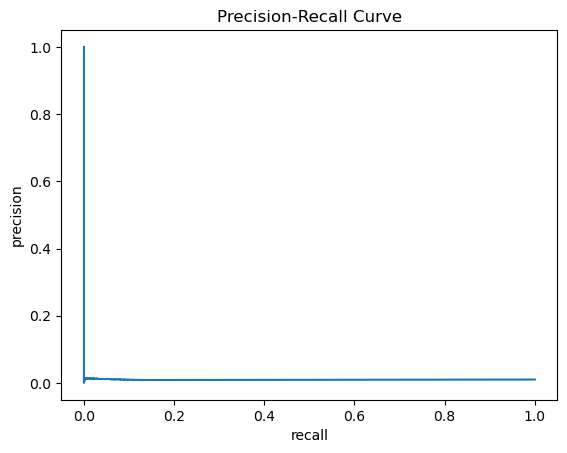

In [ ]:
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(Y_true, Y_pred)
print(precision)
print(recall)
print(thresholds)
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision-Recall Curve")
plt.show()